# K-Means Clustering with Quantum Annealing

In this notebook, we explore the implementation of K-Means Clustering for clusters with resource constraints on D-Wave's Quantum Annealong solvers.

K-Means was mapped to a Discrete Quadratic Model problem, which was then mapped to a QUBO that is solved by LeapHybridSolver.

In [47]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.datasets import make_blobs

from kmeans import solve

## Example

For testing our solution, we will generate 3 equally sized clusters of points in the (X, Y) plane. We will plot the dataset for comparing with the K-Means solution later.

In [35]:
N = 30
K = 3

In [36]:
def get_distance(i, j, df, num_colors):
    x = df.iloc[i, :num_colors].to_numpy()
    y = df.iloc[j, :num_colors].to_numpy()
    return np.linalg.norm(x-y)

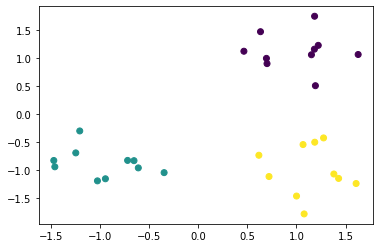

In [37]:
# generate k clusters, classical way
centers = [[1, 1], [-1, -1], [1, -1]]
sz_per_cluster = N//K
ft_dim = 2
stddev = 0.3
output_name = "tmp"
n_samples = len(centers) * sz_per_cluster
x, labels= make_blobs(
    n_samples=n_samples,
    n_features=ft_dim,
    centers=centers,
    cluster_std=stddev
)

df = pd.DataFrame(x, columns=[f"ft_{i}" for i in range(ft_dim)])
df['label']=labels
# print(df)
# print(df.iloc[2,:2].to_numpy())
df.to_csv(output_name+".csv", index=False)

plt.scatter(x[:,0], x[:,1], c=labels)
plt.savefig(output_name+".png", dpi=300)

K-Means will learn new labels for the points by trying to group them on clusters of equal size.

To do so, it will try to minize the sum of Eucliden distances among points from the same cluster.

We compute a distance matrix to feed to the K-Means algorithm, as those distances will influence the coefficients on the QUBO equation.

In [38]:
# Make distance matrix
dist_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            dist_matrix[i][j] = get_distance(i, j, df, num_colors=K)

In [48]:
label_results = solve(
    N, K, dist_matrix, gamma_distinct=1, gamma_multiple=10
)

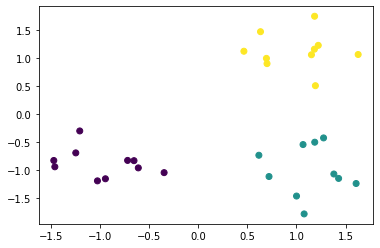

In [49]:
plt.scatter(x[:,0], x[:,1], c=label_results)

In this case, the algorithm learns the clusters and they appear to match the sets they were generated from.

Let's now analyse if the equal size constraint was respected

In [43]:
Counter(label_results)  # checking if the counts are the same

Counter({1: 10, 2: 10, 0: 10})

## What if we change K?

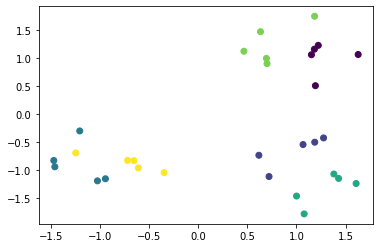

In [46]:
new_label_results = solve(
    N, 2*K, dist_matrix, gamma_distinct=1, gamma_multiple=10
)
plt.scatter(x[:,0], x[:,1], c=new_label_results)

For a larger K, the algorithm proposes new clusters. It finds new subgroups within the data, and partitions each of the original 3-clusters further apart in half. The proposed solution is reasonable. 